## https://cellxgene.cziscience.com/e/d3cb449b-c2b1-4b50-a7f1-21203535fe61.cxg/

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import decoupler as dc
# import scrublet as scr
# import muon as mu
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import re

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '241209_PDbrain_AMPPD'
# input_table = '../data/231009_PBMC_HH514.csv'

results_file = '../scanpy/{}/res.h5ad'.format(version)
results_file_mu = '../scanpy/{}/res.h5mu'.format(version)
results_file_cellxgene = '../scanpy/{}/res.cxg.h5ad'.format(version)

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

2025-03-06 12:05:22.923045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-06 12:05:22.937520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 12:05:22.952200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 12:05:22.956327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 12:05:22.969407: I tensorflow/core/platform/cpu_feature_guar

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
adata = sc.read('../data/5c56796c-849f-4919-a680-15f1a3adcd91.h5ad')
adata.var.set_index('gene_name', inplace=True)
adata.var.index = adata.var.index.astype(str)
adata.var_names_make_unique()
del adata.raw

In [4]:
adata

AnnData object with n_obs × n_vars = 2096155 × 17267
    obs: 'n_genes', 'n_counts', 'Brain_bank', 'RIN', 'path_braak_lb', 'derived_class2', 'PMI', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'genome', 'schema_reference', 'schema_version', 'title', 'uid'
    obsm: 'X_umap'

In [5]:
adata.X.max()

10.865402

In [6]:
adata.X.min()

0.0

In [7]:
adata.obs

,n_genes,n_counts,Brain_bank,RIN,path_braak_lb,derived_class2,PMI,organism_ontology_term_id,tissue_ontology_term_id,tissue_type,...,is_primary_data,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
barcodekey,,,,,,,,,,,,,,,,,,,,,
Set10_C1-AAACCCACATCACGGC,2929,5645.0,UM,4.8,3,Oligo,20.910000,NCBITaxon:9606,UBERON:0002477,tissue,...,True,oligodendrocyte,10x 3' v3,Parkinson disease,Homo sapiens,male,medial globus pallidus,European,82-year-old stage,MpT)aB)#*U
Set10_C1-AAACCCAGTAGCACAG,4395,14741.0,UD,4.4,3,Oligo,20.910000,NCBITaxon:9606,UBERON:0001384,tissue,...,True,oligodendrocyte,10x 3' v3,Parkinson disease,Homo sapiens,female,primary motor cortex,European,73-year-old stage,qFT~wG^BCg
Set10_C1-AAACCCAGTATGTCCA,3856,11005.0,UM,4.8,3,Oligo,20.910000,NCBITaxon:9606,UBERON:0002477,tissue,...,True,oligodendrocyte,10x 3' v3,Parkinson disease,Homo sapiens,male,medial globus pallidus,European,82-year-old stage,fE`VpY%8fb
Set10_C1-AAACCCAGTCCAGAAG,3387,8134.0,UD,4.4,3,Oligo,20.910000,NCBITaxon:9606,UBERON:0001384,tissue,...,True,oligodendrocyte,10x 3' v3,Parkinson disease,Homo sapiens,female,primary motor cortex,European,73-year-old stage,g1Lr8^y)O(
Set10_C1-AAACCCATCCACGTAA,2366,4583.0,UD,4.4,3,Astro,20.910000,NCBITaxon:9606,UBERON:0001384,tissue,...,True,astrocyte,10x 3' v3,Parkinson disease,Homo sapiens,female,primary motor cortex,European,73-year-old stage,MR9tUCifao
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
set7A_2-TTTGTTGTCAAGAGTA,2976,6626.0,MSSM,4.7,1,Oligo,10.166667,NCBITaxon:9606,UBERON:0001384,tissue,...,True,oligodendrocyte,10x 3' v3,normal,Homo sapiens,female,primary motor cortex,European,78-year-old stage,25FK4DT!Rl
set7A_2-TTTGTTGTCACTCTTA,3947,11414.0,MSSM,4.3,2,EN,10.166667,NCBITaxon:9606,UBERON:0002436,tissue,...,True,glutamatergic neuron,10x 3' v3,Parkinson disease,Homo sapiens,female,primary visual cortex,European,81-year-old stage,PdMVWS9R^v
set7A_2-TTTGTTGTCAGTGCGC,3212,8142.0,MSSM,3.0,4,Micro_PVM,10.166667,NCBITaxon:9606,UBERON:0001384,tissue,...,True,central nervous system macrophage,10x 3' v3,Parkinson disease,Homo sapiens,male,primary motor cortex,European,84-year-old stage,Q&?JBHEFAz


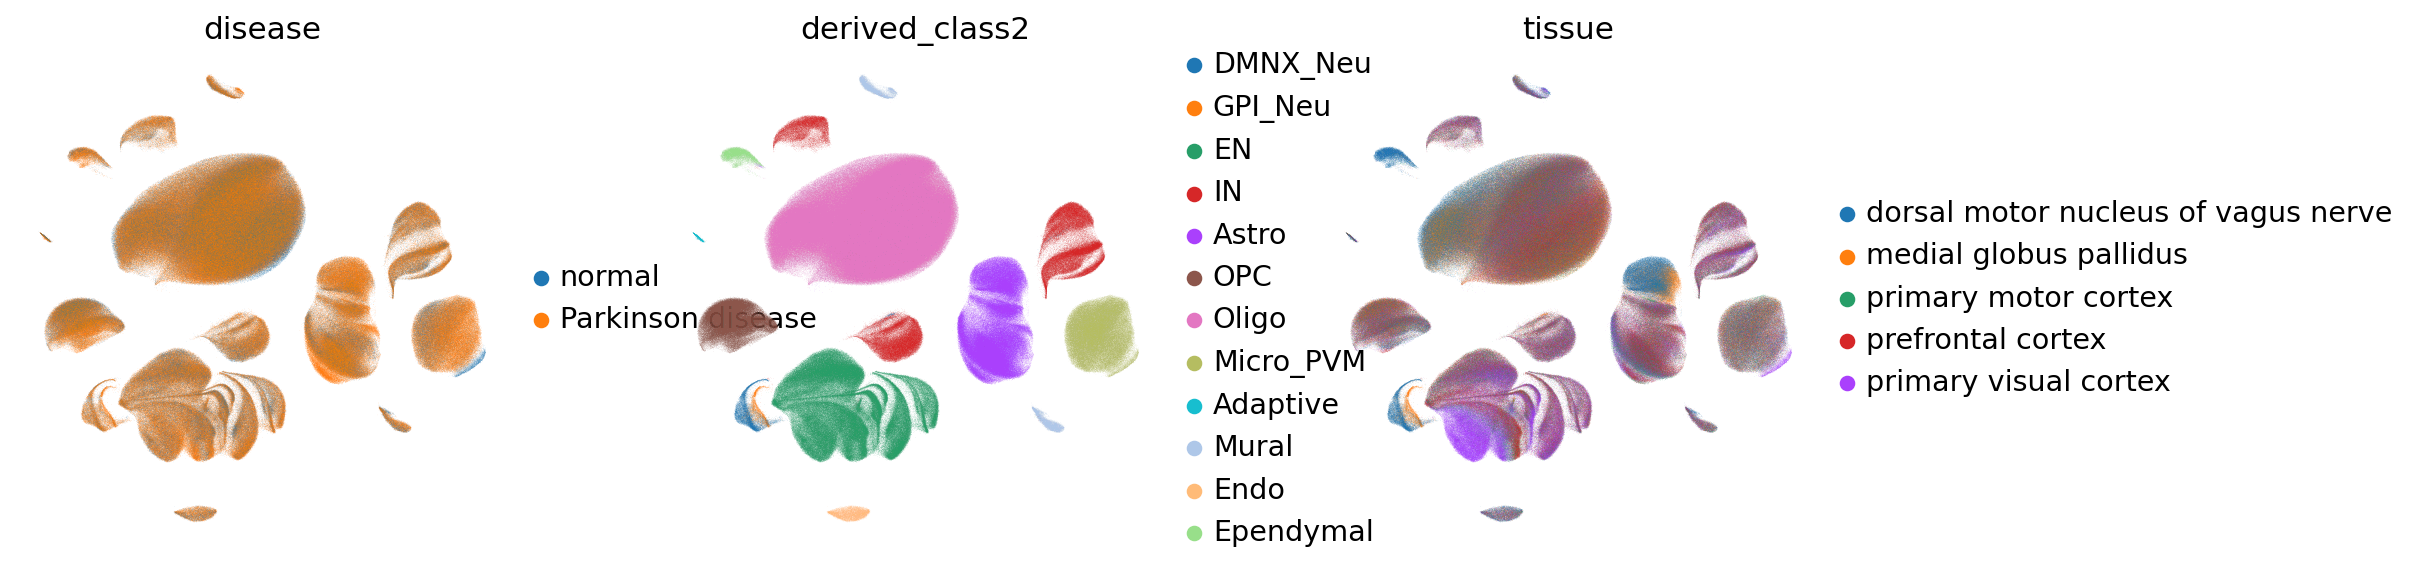

In [8]:
sc.pl.umap(adata, color=['disease', 'derived_class2', 'tissue'])

In [9]:
adata_cxg = sc.AnnData(adata.X)
adata_cxg.obs = adata.obs
adata_cxg.obsm = adata.obsm
adata_cxg.var.index = adata.var.index
sc.pp.subsample(adata_cxg, n_obs=200000)
adata_cxg.write('../data/PDnuclei_AMPPD.subsample200000.cxg.h5ad')

In [5]:
# sc.pp.subsample(adata, n_obs=200000)
adata = adata[adata.obs['derived_class2'] == 'Micro_PVM']

In [11]:
df_degs = pd.read_csv('/home/yy693/pi_hafler/ASAP/scanpy/241028_CSF_downstream/graph/deg_CSF Mac_group_RBD.csv', index_col=0)

In [12]:
df_degs

,names,scores,logfoldchanges,pvals,pvals_adj,neg_log10_pvals_adj,mean
0,MT-ATP8,63.518170,1.789903,0.000000e+00,0.000000e+00,200.000000,1.200095
1,HLA-DQA2,31.965113,1.347907,1.328631e-213,8.023270e-210,200.000000,0.818719
2,DLGAP2,30.587502,4.287176,1.479882e-201,7.149309e-198,197.145736,0.055062
3,ENSG00000278996,28.433815,1.327079,2.614265e-172,1.052459e-168,167.977795,0.826684
4,HLA-DQB2,28.368900,1.758952,3.579633e-172,1.235229e-168,167.908253,0.140919
...,...,...,...,...,...,...,...
24150,EEF1A1,-22.851433,-0.204739,2.107913e-112,2.213767e-109,108.654868,4.596119
24151,RPS4Y1,-24.488081,-0.617373,1.960239e-128,3.642274e-125,124.438627,1.300633
24152,ENSG00000273149,-26.189083,-1.148974,1.235108e-144,2.486169e-141,140.604469,0.752696
24153,HLA-B,-32.408543,-0.657486,2.143867e-216,1.726171e-212,200.000000,2.621798


In [13]:
th_padj = 1e-2
th_lfc = 0.2
th_mean = 0.5

In [14]:
df_degs_up = df_degs[(df_degs['pvals_adj'] < th_padj) & (df_degs['logfoldchanges'] > th_lfc)  & (df_degs['mean'] > th_mean)]

In [15]:
df_degs_up.head(100)

,names,scores,logfoldchanges,pvals,pvals_adj,neg_log10_pvals_adj,mean
0,MT-ATP8,63.518170,1.789903,0.000000e+00,0.000000e+00,200.000000,1.200095
1,HLA-DQA2,31.965113,1.347907,1.328631e-213,8.023270e-210,200.000000,0.818719
3,ENSG00000278996,28.433815,1.327079,2.614265e-172,1.052459e-168,167.977795,0.826684
6,MT-ND3,28.067745,0.726988,1.043748e-165,2.801305e-162,161.552640,2.404480
9,F13A1,24.323185,0.690185,2.031646e-126,3.505315e-123,122.455273,1.444279
...,...,...,...,...,...,...,...
152,NAP1L1,14.239243,0.385797,1.669571e-45,2.156604e-43,42.666230,0.913574
158,ARHGAP15,14.155951,0.421114,5.209026e-45,6.519379e-43,42.185794,0.710160
162,CTNNB1,14.068193,0.456582,1.739624e-44,2.133026e-42,41.671004,0.550968
164,IL10RA,14.047550,0.390356,2.392476e-44,2.904033e-42,41.536999,0.815763


In [16]:
df_degs_up['names']

0               MT-ATP8
1              HLA-DQA2
3       ENSG00000278996
6                MT-ND3
9                 F13A1
             ...       
2576               BZW1
2665               LCP2
2845               FLNA
2894              BASP1
2943             LILRB4
Name: names, Length: 368, dtype: object

In [17]:
sc.tl.score_genes(adata, gene_list=df_degs_up['names'], score_name='CSFmac_up')

computing score 'CSFmac_up'
       'ENSG00000280441', 'MT-ND4L', 'CSF2RA', 'MT-CYB', 'NEAT1', 'MT-CO1',
       'MT-ND2', 'MT-CO3', 'MALAT1', 'TALAM1', 'MT-ND4', 'CYBB', 'MT-ND1',
       'IL13RA1', 'SH3KBP1', 'MT-ATP6', 'SNHG8', 'MT-CO2', 'ATRX', 'CYP51A1',
       'TSC22D3', 'VSIG4', 'EIF2S3', 'SAT1', 'SEPTIN6', 'SNHG6', 'FLNA'],
      dtype='object')


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


    finished: added
    'CSFmac_up', score of gene set (adata.obs).
    772 total control genes are used. (0:00:11)


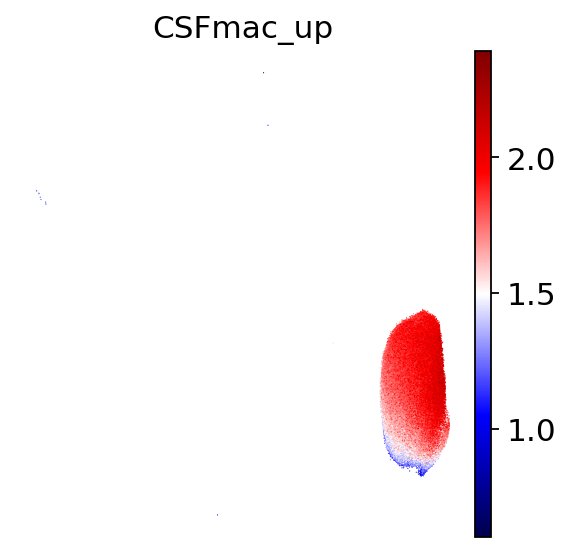

In [18]:
sc.pl.umap(adata, color='CSFmac_up', cmap='seismic')

In [22]:
df_score = adata.obs.loc[adata.obs.derived_class2=='Micro_PVM', ['CSFmac_up', 'disease', 'donor_id', 'tissue', 'path_braak_lb']]
df_score

,CSFmac_up,disease,donor_id,tissue,path_braak_lb
barcodekey,,,,,
Set10_C1-AAAGAACAGGAACGAA,1.832190,Parkinson disease,CASE_2,primary motor cortex,3
Set10_C1-AAAGAACGTAACGCGA,1.704750,Parkinson disease,CASE_2,primary motor cortex,3
Set10_C1-AAAGGTAAGTCACGCC,1.848632,Parkinson disease,CASE_2,primary motor cortex,3
Set10_C1-AAAGTCCAGCGTATAA,1.851779,Parkinson disease,CASE_2,primary motor cortex,3
Set10_C1-AAAGTCCCATTGCAAC,1.932471,Parkinson disease,CASE_2,primary motor cortex,3
...,...,...,...,...,...
set7A_2-TTTCATGAGGGTACAC,1.592379,Parkinson disease,CASE_18,primary motor cortex,4
set7A_2-TTTCCTCTCCCTTGTG,1.623417,normal,CTRL_16,primary motor cortex,1
set7A_2-TTTGGTTTCAAGATAG,1.181907,Parkinson disease,CASE_18,primary motor cortex,4


In [23]:
adata.obs

,n_genes,n_counts,Brain_bank,RIN,path_braak_lb,derived_class2,PMI,organism_ontology_term_id,tissue_ontology_term_id,tissue_type,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,CSFmac_up
barcodekey,,,,,,,,,,,,,,,,,,,,,
Set10_C1-AAAGAACAGGAACGAA,4454,11762.0,UD,4.4,3,Micro_PVM,20.910000,NCBITaxon:9606,UBERON:0001384,tissue,...,central nervous system macrophage,10x 3' v3,Parkinson disease,Homo sapiens,female,primary motor cortex,European,73-year-old stage,N~}#5Xra48,1.832190
Set10_C1-AAAGAACGTAACGCGA,2810,5877.0,UD,4.4,3,Micro_PVM,20.910000,NCBITaxon:9606,UBERON:0001384,tissue,...,central nervous system macrophage,10x 3' v3,Parkinson disease,Homo sapiens,female,primary motor cortex,European,73-year-old stage,hNU0sEZq*z,1.704750
Set10_C1-AAAGGTAAGTCACGCC,3503,7703.0,UD,4.4,3,Micro_PVM,20.910000,NCBITaxon:9606,UBERON:0001384,tissue,...,central nervous system macrophage,10x 3' v3,Parkinson disease,Homo sapiens,female,primary motor cortex,European,73-year-old stage,ckW0HlN&aZ,1.848632
Set10_C1-AAAGTCCAGCGTATAA,4727,13877.0,UD,4.4,3,Micro_PVM,20.910000,NCBITaxon:9606,UBERON:0001384,tissue,...,central nervous system macrophage,10x 3' v3,Parkinson disease,Homo sapiens,female,primary motor cortex,European,73-year-old stage,XPOky!XK`p,1.851779
Set10_C1-AAAGTCCCATTGCAAC,3677,8079.0,UD,4.4,3,Micro_PVM,20.910000,NCBITaxon:9606,UBERON:0001384,tissue,...,central nervous system macrophage,10x 3' v3,Parkinson disease,Homo sapiens,female,primary motor cortex,European,73-year-old stage,Gyic}6svm4,1.932471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
set7A_2-TTTCATGAGGGTACAC,2272,5319.0,MSSM,3.0,4,Micro_PVM,10.166667,NCBITaxon:9606,UBERON:0001384,tissue,...,central nervous system macrophage,10x 3' v3,Parkinson disease,Homo sapiens,male,primary motor cortex,European,84-year-old stage,^GEBvw?zzK,1.592379
set7A_2-TTTCCTCTCCCTTGTG,2457,4676.0,MSSM,4.7,1,Micro_PVM,10.166667,NCBITaxon:9606,UBERON:0001384,tissue,...,central nervous system macrophage,10x 3' v3,normal,Homo sapiens,female,primary motor cortex,European,78-year-old stage,>`@JTL>AcT,1.623417
set7A_2-TTTGGTTTCAAGATAG,1728,3151.0,MSSM,3.0,4,Micro_PVM,10.166667,NCBITaxon:9606,UBERON:0001384,tissue,...,central nervous system macrophage,10x 3' v3,Parkinson disease,Homo sapiens,male,primary motor cortex,European,84-year-old stage,-g0n84;Cn<,1.181907


In [24]:
df_score_mean = df_score[['tissue', 'donor_id', 'disease', 'CSFmac_up', 'path_braak_lb']].groupby(['tissue', 'disease', 'donor_id', 'path_braak_lb']).mean().reset_index()

In [25]:
df_score_mean

,tissue,disease,donor_id,path_braak_lb,CSFmac_up
0,dorsal motor nucleus of vagus nerve,normal,CASE_53,0,NaN
1,dorsal motor nucleus of vagus nerve,normal,CASE_53,1,NaN
2,dorsal motor nucleus of vagus nerve,normal,CASE_53,2,NaN
3,dorsal motor nucleus of vagus nerve,normal,CASE_53,3,NaN
4,dorsal motor nucleus of vagus nerve,normal,CASE_53,4,NaN
...,...,...,...,...,...
6785,primary visual cortex,Parkinson disease,CASE_30,2,NaN
6786,primary visual cortex,Parkinson disease,CASE_30,3,NaN
6787,primary visual cortex,Parkinson disease,CASE_30,4,NaN
6788,primary visual cortex,Parkinson disease,CASE_30,5,NaN


([0, 1, 2, 3, 4],
 [Text(0, 0, 'dorsal motor nucleus of vagus nerve'),
  Text(1, 0, 'medial globus pallidus'),
  Text(2, 0, 'primary motor cortex'),
  Text(3, 0, 'prefrontal cortex'),
  Text(4, 0, 'primary visual cortex')])

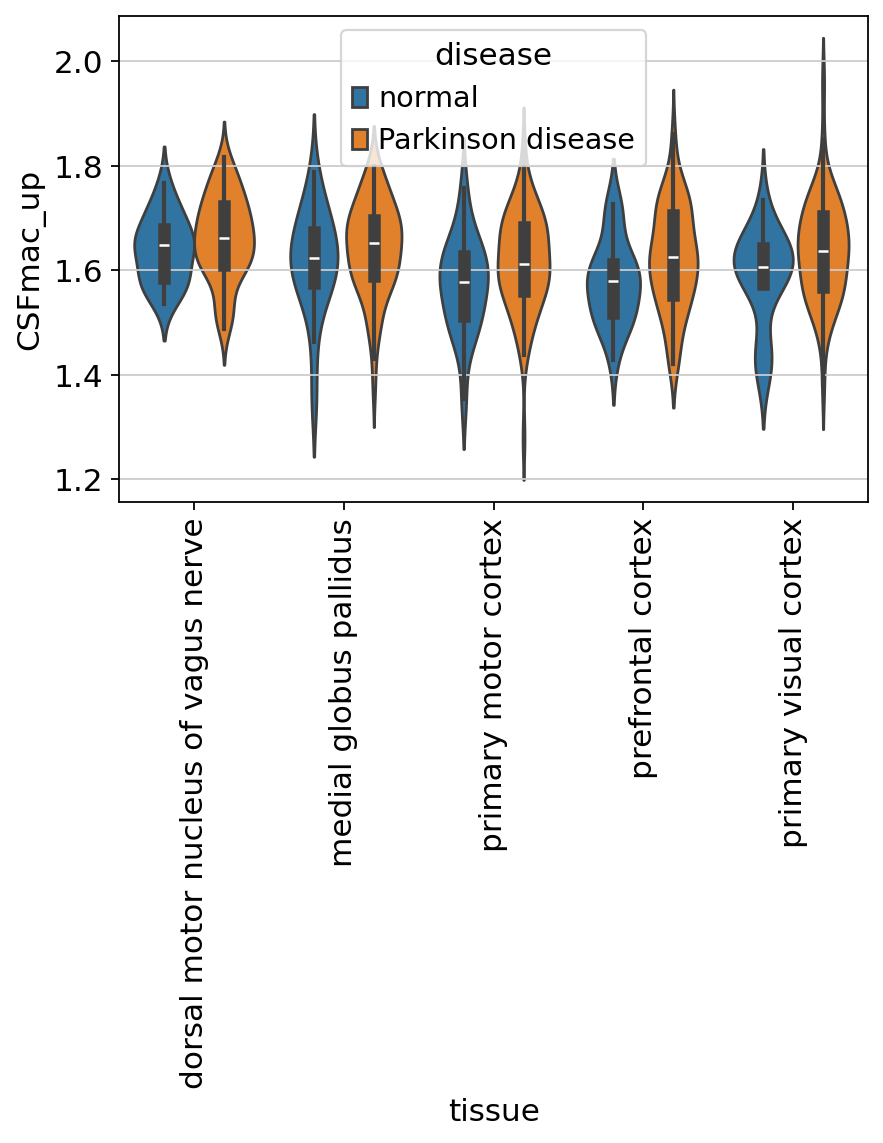

In [26]:
plt.figure(figsize=(6,4))
# sns.swarmplot(data=df_score_mean, x='tissue', y='CSFmac_up', hue='disease', dodge=True)
sns.violinplot(data=df_score_mean, x='tissue', y='CSFmac_up', hue='disease', dodge=True)
plt.xticks(rotation=90)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

medial globus pallidus_normal vs. medial globus pallidus_Parkinson disease: Mann-Whitney-Wilcoxon test two-sided, P_val:3.240e-01 U_stat=5.660e+02
dorsal motor nucleus of vagus nerve_normal vs. dorsal motor nucleus of vagus nerve_Parkinson disease: Mann-Whitney-Wilcoxon test two-sided, P_val:2.089e-01 U_stat=5.390e+02
primary motor cortex_normal vs. primary motor cortex_Parkinson disease: Mann-Whitney-Wilcoxon test two-sided, P_val:4.077e-02 U_stat=5.460e+02
prefrontal cortex_normal vs. prefrontal cortex_Parkinson disease: Mann-Whitney-Wilcoxon test two-sided, P_val:3.826e-02 U_stat=4.860e+02
primary visual cortex_normal vs. primary visual cortex_Parkinson disease: Mann-Whitney-Wilcoxon test two-sided, P_val:9.024e-02 U_stat=4.970e+02


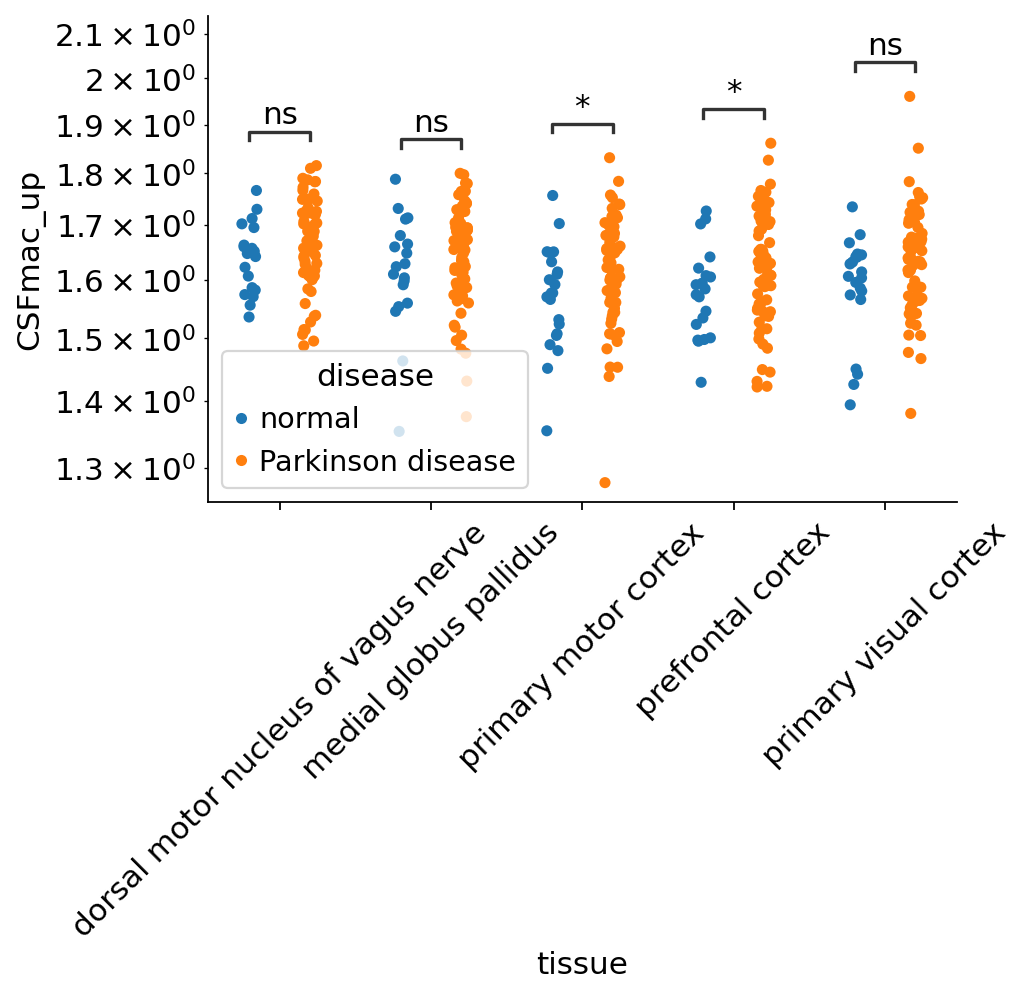

In [ ]:
from statannotations.Annotator import Annotator

significanceComparisons = [(('dorsal motor nucleus of vagus nerve', 'normal'), ('dorsal motor nucleus of vagus nerve', 'Parkinson disease')), 
(('medial globus pallidus', 'normal'), ('medial globus pallidus', 'Parkinson disease')),
(('primary motor cortex', 'normal'), ('primary motor cortex', 'Parkinson disease')),
(('prefrontal cortex', 'normal'), ('prefrontal cortex', 'Parkinson disease')),
(('primary visual cortex', 'normal'), ('primary visual cortex', 'Parkinson disease'))]

fig_args = {'x': 'tissue',
            'y': 'CSFmac_up',
            'hue':'disease',
            'data': df_score_mean,
            'dodge': True}

configuration = {'test':'Mann-Whitney',
                 'comparisons_correction':None,
                 'text_format':'star'}

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_yscale('log')
plt.xticks(rotation=45)
sns.stripplot(ax=ax, **fig_args)
sns.despine()
annotator = Annotator(ax=ax, pairs=significanceComparisons,
                      **fig_args, plot='stripplot')
annotator.configure(**configuration).apply_test().annotate()
fig.savefig(f'../scanpy/{version}/graph/CSFmac_up_microglia.pdf', bbox_inches='tight')

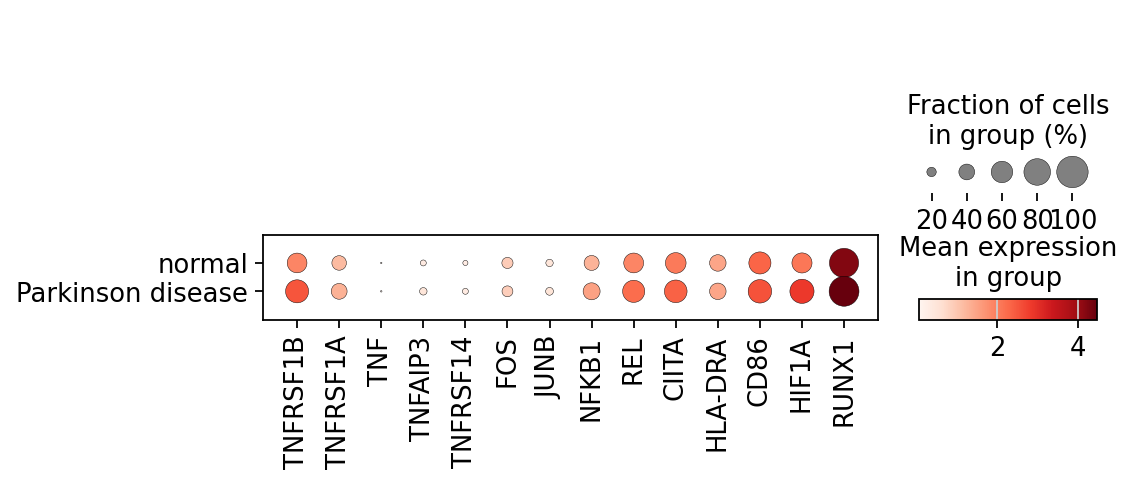

In [6]:
sc.pl.dotplot(adata[(adata.obs.derived_class2=='Micro_PVM') & (adata.obs.tissue=='prefrontal cortex')],
            var_names=['TNFRSF1B', 'TNFRSF1A', 'TNF', 'TNFAIP3', 'TNFRSF14', 'FOS', 'JUNB', 'NFKB1', 'REL', 
            'CIITA', 'HLA-DRA', 'CD86', 'HIF1A', 'RUNX1'],
            groupby='disease',
            # standard_scale='var', 
            save='tnf_noscale'
            )